# Intialize

In [28]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy_sz import Class
import os
import time

font = {'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})


# the parameters needed for cosmology:
# use the last column of Planck 2018 (https://arxiv.org/pdf/1807.06209.pdf)
# TT,TE,EE+lowE+lensing+BAO
cosmo_params = {
'omega_b': 0.02242,
'omega_cdm':  0.11933,
'H0': 67.66,
'tau_reio': 0.0561,
'ln10^{10}A_s': 3.047,
'n_s': 0.9665,

'k_pivot': 0.05,
'N_ncdm': 1,
'N_ur': 2.0328,
'm_ncdm': 0.06    

}




common_params = {

'z_min' : 0.005,
'z_max' : 3.0,
'M_min' : 1.0e10, 
'M_max' : 3.5e15,
    

'delta for galaxies' : "200c",
'delta for matter density' : "200c",
'delta for electron density':"200c",    

'mass function' : 'T08M200c',
'concentration parameter' : 'B13',

'redshift_epsabs': 1.0e-40,
'redshift_epsrel': 0.0005,
'mass_epsabs': 1.0e-40,
'mass_epsrel': 0.0005,


'ell_max': 1600.0,
'ell_min': 2.0,
'dell': 10,

'non_linear' : 'hmcode',
'pk_nonlinear_for_vrms2' : 1,
'hm_consistency' : 1,
    
'f_free' : 1.0,
    

# 'ndim_masses': 150,
# 'ndim_redshifts': 150,

# 'P_k_max_h/Mpc': 50.0,
# 'k_min_for_pk_class_sz': 0.0001,
# 'k_max_for_pk_class_sz': 10.0,
# 'k_per_decade_class_sz': 20.0,
    
'x_out_truncated_nfw_profile':1.,
'x_out_truncated_density_profile (electrons)': 1., 
'use_xout_in_density_profile_from_enclosed_mass': 1,
'normalize_gas_density_profile': 0, # only useful when we dont set xout_in_density_profile_from_enclosed_mass, e.g., computing the transform as in Cayuso et al 2021 
    
# 'ksz template file': path_to_kSZ2X_2022+'external_data/dl_ksz_hm_agn_1p2h_uK2_170422.txt',
# 'ksz template file, reio contribution': path_to_kSZ2X_2022+'external_data/dl_ksz_hm_agn_1p2h_uK2_170422_zeros.txt',

# for the truncation of the pressure profile important!
'x_outSZ': 4.,
'truncate_wrt_rvir':0,
}

# The density profile

In [2]:
%%time
M = Class()
M.set(cosmo_params)
M.set({
# class_sz parameters:
'output':'m200m_to_m200c,m200c_to_m200m,m200c_to_m500c',

'tabulate_rhob_xout_at_m_and_z': 1,
'gas profile':'B16',
'gas profile mode' : 'custom',
    
        })
M.compute()

CPU times: user 20.2 s, sys: 43 ms, total: 20.2 s
Wall time: 2.5 s


In [3]:
# chose a mass and redshift for a given halo of interest
# amodeo et al: m = 3e13 Msun/h at z=0.55
z = 0.25
# m200m = 3e14
# convert to 200c for b16 profile
m200c = 3.3e13*M.h()#M.get_m200m_to_m200c_at_z_and_M(z,m200m)
m200m = M.get_m200c_to_m200m_at_z_and_M(z,m200c)


lambda_min = 0.1
lambda_max = 200
n_lambda = 500
lambda_array = np.geomspace(lambda_min,lambda_max,n_lambda)

# store the radial profiles of the gas
rho_gas_nfw = np.vectorize(M.get_gas_profile_at_x_M_z_nfw_200c)
rho_gas_b16 = np.vectorize(M.get_gas_profile_at_x_M_z_b16_200c)

# normalized radial array for b16:
x_200c = lambda_array

# dimensonfull radial array:
r200c = M.get_r_delta_of_m_delta_at_z(200,m200c,z)
r = x_200c*r200c
theta_arcmin = M.get_rad_to_arcmin(r/M.get_dA(z))

# normalized radial array for nfw:
# r200m = M.get_r_delta_of_m_delta_at_z(200*M.Om_m(z),m200m,z)
# c200m = M.get_c200m_at_m_and_z_B13(m200m,z)
c200c = M.get_c200c_at_m_and_z_B13(m200c,z)
# rs_200m = r200m/c200m
# xs_200m =  r/rs_200m
rs_200c = r200c/c200c
xs_200c=  r/rs_200c

def x200c_to_theta_arcmin(X):
    return M.get_rad_to_arcmin(r200c*X/M.get_dA(z))
def theta_arcmin_to_x200c(X):
    theta_rad = M.get_arcmin_to_rad(X)
    r = M.get_dA(z)*theta_rad
    return r/r200c

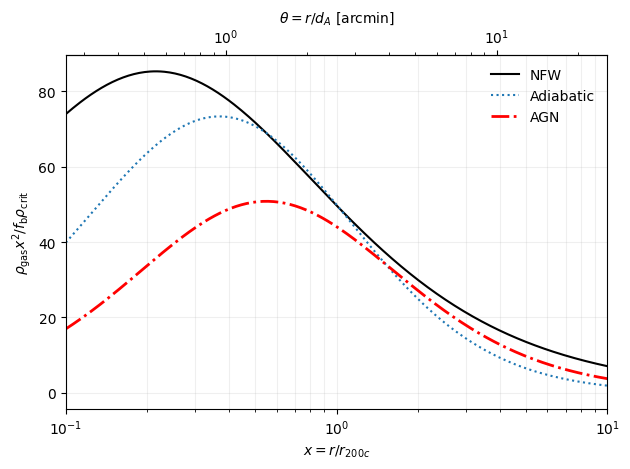

In [4]:
fig = plt.figure()
ax1 = fig.add_subplot(111)


rho_norm_nfw = rho_gas_nfw(xs_200c,m200c,z)/M.get_rho_crit_at_z(z)/M.get_f_b()
ax1.plot(x_200c,rho_norm_nfw*x_200c**2,label = 'NFW',c='k')

A_rho0 = 1.9e4
A_alpha = 0.70
A_beta = 4.43

alpha_m_rho0 = 0.09
alpha_m_alpha = -0.017
alpha_m_beta = 0.005

alpha_z_rho0 = -0.95
alpha_z_alpha = 0.27
alpha_z_beta = 0.037
gamma = -0.2
xc = 0.5

rho_norm_b16 = rho_gas_b16(x_200c,
                           m200c,
                           z,
                           A_rho0 = A_rho0,
                           A_alpha = A_alpha,
                           A_beta = A_beta,
                           alpha_m_rho0 = alpha_m_rho0,
                           alpha_m_alpha = alpha_m_alpha,
                           alpha_m_beta = alpha_m_beta,
                           alpha_z_rho0 = alpha_z_rho0,
                           alpha_z_alpha = alpha_z_alpha,
                           alpha_z_beta = alpha_z_beta,
                           gamma=gamma,
                           xc = xc)/M.get_rho_crit_at_z(z)/M.get_f_b()
ax1.plot(x_200c,rho_norm_b16*x_200c**2, label = r'Adiabatic',ls=':')




A_rho0 = 4.e3
A_alpha = 0.88
A_beta = 3.83

alpha_m_rho0 = 0.29
alpha_m_alpha = -0.03
alpha_m_beta = 0.04

alpha_z_rho0 = -0.66
alpha_z_alpha = 0.19
alpha_z_beta = -0.025
gamma = -0.2
xc = 0.5

rho_norm_b16 = rho_gas_b16(x_200c,
                           m200c,
                           z,
                           A_rho0 = A_rho0,
                           A_alpha = A_alpha,
                           A_beta = A_beta,
                           alpha_m_rho0 = alpha_m_rho0,
                           alpha_m_alpha = alpha_m_alpha,
                           alpha_m_beta = alpha_m_beta,
                           alpha_z_rho0 = alpha_z_rho0,
                           alpha_z_alpha = alpha_z_alpha,
                           alpha_z_beta = alpha_z_beta,
                           gamma=gamma,
                           xc = xc)/M.get_rho_crit_at_z(z)/M.get_f_b()
ax1.plot(x_200c,rho_norm_b16*x_200c**2, label = r'AGN',ls='-.',c='r',lw=2.)




ax1.set_xscale('log')
ax1.legend(frameon=False)
ax1.set_xlabel(r'$x=r/r_{200c}$')
ax1.set_ylabel(r'$\rho_\mathrm{gas}x^2/f_\mathrm{b}\rho_\mathrm{crit}$')

plt.grid(which='both',alpha=0.2)
secax = ax1.secondary_xaxis('top', functions=(x200c_to_theta_arcmin, theta_arcmin_to_x200c))

secax.set_xlabel(r'$\theta = r/d_A$ [arcmin]')
ax1.set_xlim(1e-1,1e1)

fig.tight_layout()
plt.savefig('figures/Battaglia_density_profiles.pdf')


# The 2-halo terms of the density and pressure profile

In [5]:
# pick a mass and a redshift
m = 3e13*cosmo_params['H0']/100. # amodeo: 3e13 Msun
z = 0.55 # amodeo: z=0.55

In [6]:
%%time
# initialize call 
M = Class()

M.set(common_params)
M.set(cosmo_params)
M.set({

'output': 'pressure_profile_2h,gas_density_profile_2h',


'pressure profile':'B12',
'gas profile':'B16',
'gas profile mode' : 'custom', # important to read values of parameters
'use_xout_in_density_profile_from_enclosed_mass' : 1,
'n_z_m_to_xout' : 30,
'n_mass_m_to_xout' : 30,
    
    
'M_min' : 1.0e10, 
'M_max' : 5e15,

    
'n_k_pressure_profile' :50, # this is l/ls # default 80
'n_m_pressure_profile' :30, # default: 100, decrease for faster
'n_z_pressure_profile' :30, # default: 100, decrease for faster

'k_min_gas_pressure_profile' : 1e-3, # l/ls hence no need for very extreme values...
'k_max_gas_pressure_profile' : 1e2, 

'k_min_gas_pressure_profile_2h' : 1e-3, # l/ls hence no need for very extreme values...
'k_max_gas_pressure_profile_2h' : 1e2, 
    
    
'n_k_density_profile' :50, # default 80
'n_m_density_profile' :30, # default: 100, decrease for faster
'n_z_density_profile' :30, # default: 100, decrease for faster

'k_min_gas_density_profile' : 1e-3,
'k_max_gas_density_profile' : 1e2, 
    
'k_min_samp_fftw' : 1e-3,
'k_max_samp_fftw' : 1e3,
'N_samp_fftw' : 1024,
    
    
'hm_consistency' : 0,
    
    
'use_fft_for_profiles_transform' : 1,
    
    
'x_min_gas_density_fftw' : 1e-5,
'x_max_gas_density_fftw' : 1e2,
    
    
'x_min_gas_pressure_fftw' : 1e-5,
'x_max_gas_pressure_fftw' : 1e2,
})    

M.compute_class_szfast()

CPU times: user 7.47 s, sys: 205 ms, total: 7.68 s
Wall time: 1.79 s


# Plot all together

In [7]:
rho_gas_b16 = np.vectorize(M.get_gas_profile_at_x_M_z_b16_200c)
pe = np.vectorize(M.get_pressure_P_over_P_delta_at_x_M_z_b12_200c)
rho2h_internal = np.vectorize(M.get_rho_2h_at_r_and_m_and_z)
pe2h_internal = np.vectorize(M.get_gas_pressure_2h_at_r_and_m_and_z)

# mass and redshift of interest:
# (add more blocks if you want more m's and z')
mp = m # in msun/h, 200c definition
zp = z
r200c = M.get_r_delta_of_m_delta_at_z(200,mp,zp) # just here for the record, needed for 2-halo
x_200c = np.geomspace(0.01,30,200) # this is r/r200c

# 1-halo density

A_rho0p = 4.e3
A_alphap = 0.88
A_betap = 3.83

alpha_m_rho0p = 0.29
alpha_m_alphap = -0.03
alpha_m_betap = 0.04

alpha_z_rho0p = -0.66
alpha_z_alphap = 0.19
alpha_z_betap = -0.025
gammap = -0.2
xcp = 0.5
cp = 0.

rho_norm_b16 = rho_gas_b16(x_200c,
                           mp,
                           zp,
                           c_asked = cp,
                           A_rho0 = A_rho0p,
                           A_alpha = A_alphap,
                           A_beta = A_betap,
                           alpha_m_rho0 = alpha_m_rho0p,
                           alpha_m_alpha = alpha_m_alphap,
                           alpha_m_beta = alpha_m_betap,
                           alphap_m_rho0 = alpha_m_rho0p,
                           alphap_m_alpha = alpha_m_alphap,
                           alphap_m_beta = alpha_m_betap,
                           alpha_z_rho0 = alpha_z_rho0p,
                           alpha_z_alpha = alpha_z_alphap,
                           alpha_z_beta = alpha_z_betap,
                           gamma=gammap,
                           xc = xcp)/M.get_rho_crit_at_z(zp)/M.get_f_b()



# 2-halo contribution
r = x_200c*r200c
rho_2h = rho2h_internal(r,mp,zp)


# 1-halo pressure

P0_B12p = 18.1
beta_B12p = 4.35
alpha_B12p = 1.
gamma_B12p = -0.3
xc_B12p = 0.497

alpha_m_P0_B12p = 0.154
alpha_m_xc_B12p = -0.00865
alpha_m_beta_B12p = 0.0393

alpha_z_P0_B12p = -0.758
alpha_z_xc_B12p = 0.731
alpha_z_beta_B12p = 0.415
cp = 0.


pe1h = pe(x_200c,
          mp,
          zp,
          c_asked = cp,
          A_P0 = P0_B12p,
          A_xc = xc_B12p,
          A_beta = beta_B12p,
          alpha_m_P0 = alpha_m_P0_B12p,
          alpha_m_xc = alpha_m_xc_B12p,
          alpha_m_beta = alpha_m_beta_B12p,
          alphap_m_P0 = alpha_m_P0_B12p,
          alphap_m_xc = alpha_m_xc_B12p,
          alphap_m_beta = alpha_m_beta_B12p,
          alpha_z_P0 = alpha_z_P0_B12p,
          alpha_z_xc = alpha_z_xc_B12p,
          alpha_z_beta = alpha_z_beta_B12p,
          alpha = alpha_B12p,
          gamma = gamma_B12p)

pe200 = M.get_P_delta_at_m_and_z_b12(mp,zp)

rho_1h = rho_norm_b16
rho_2h = rho2h_internal(r,mp,zp)

pe_1h = pe1h
pe_2h = pe2h_internal(r,mp,zp)/pe200

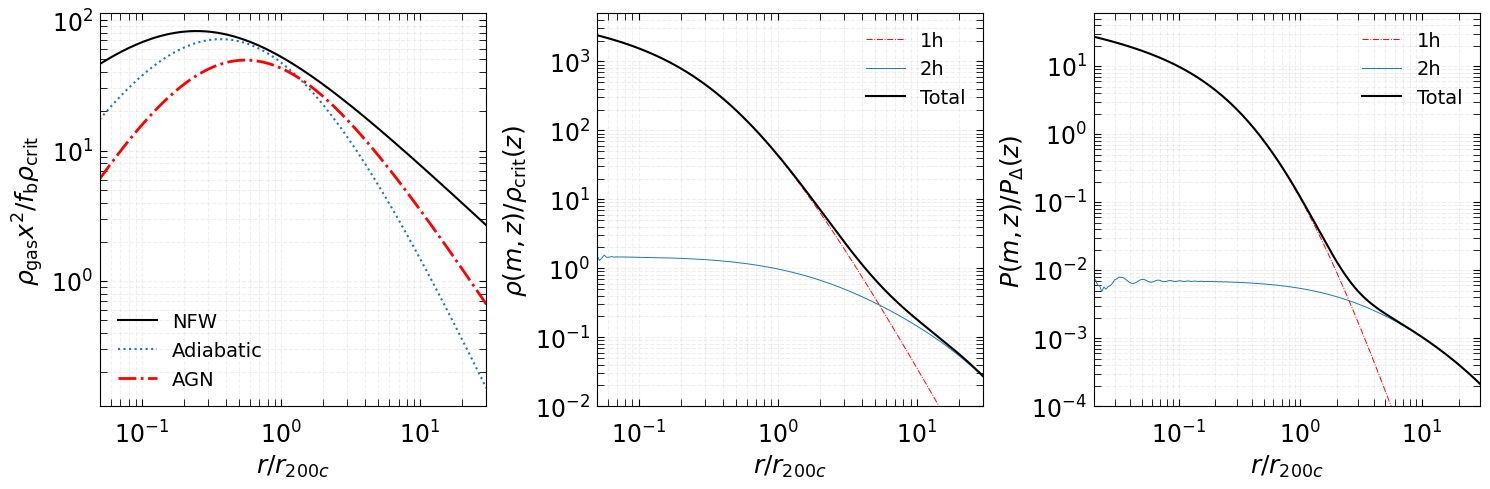

In [8]:

label_size = 17
title_size = 18
legend_size = 13
handle_length = 1.5
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))


ax = ax1
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)
ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')


# dimensonfull radial array:
r200c = M.get_r_delta_of_m_delta_at_z(200,m200c,z)
r = x_200c*r200c
theta_arcmin = M.get_rad_to_arcmin(r/M.get_dA(z))

# normalized radial array for nfw:
# r200m = M.get_r_delta_of_m_delta_at_z(200*M.Om_m(z),m200m,z)
# c200m = M.get_c200m_at_m_and_z_B13(m200m,z)
c200c = M.get_c200c_at_m_and_z_B13(m200c,z)
# rs_200m = r200m/c200m
# xs_200m =  r/rs_200m
rs_200c = r200c/c200c
xs_200c=  r/rs_200c

rho_norm_nfw = rho_gas_nfw(xs_200c,m200c,z)/M.get_rho_crit_at_z(z)/M.get_f_b()
ax1.plot(x_200c,rho_norm_nfw*x_200c**2,label = 'NFW',c='k')

A_rho0 = 1.9e4
A_alpha = 0.70
A_beta = 4.43

alpha_m_rho0 = 0.09
alpha_m_alpha = -0.017
alpha_m_beta = 0.005

alpha_z_rho0 = -0.95
alpha_z_alpha = 0.27
alpha_z_beta = 0.037
gamma = -0.2
xc = 0.5

rho_norm_b16 = rho_gas_b16(x_200c,
                           m200c,
                           z,
                           A_rho0 = A_rho0,
                           A_alpha = A_alpha,
                           A_beta = A_beta,
                           alpha_m_rho0 = alpha_m_rho0,
                           alpha_m_alpha = alpha_m_alpha,
                           alpha_m_beta = alpha_m_beta,
                           alpha_z_rho0 = alpha_z_rho0,
                           alpha_z_alpha = alpha_z_alpha,
                           alpha_z_beta = alpha_z_beta,
                           gamma=gamma,
                           xc = xc)/M.get_rho_crit_at_z(z)/M.get_f_b()
ax1.plot(x_200c,rho_norm_b16*x_200c**2, label = r'Adiabatic',ls=':')




A_rho0 = 4.e3
A_alpha = 0.88
A_beta = 3.83

alpha_m_rho0 = 0.29
alpha_m_alpha = -0.03
alpha_m_beta = 0.04

alpha_z_rho0 = -0.66
alpha_z_alpha = 0.19
alpha_z_beta = -0.025
gamma = -0.2
xc = 0.5

rho_norm_b16 = rho_gas_b16(x_200c,
                           m200c,
                           z,
                           A_rho0 = A_rho0,
                           A_alpha = A_alpha,
                           A_beta = A_beta,
                           alpha_m_rho0 = alpha_m_rho0,
                           alpha_m_alpha = alpha_m_alpha,
                           alpha_m_beta = alpha_m_beta,
                           alpha_z_rho0 = alpha_z_rho0,
                           alpha_z_alpha = alpha_z_alpha,
                           alpha_z_beta = alpha_z_beta,
                           gamma=gamma,
                           xc = xc)/M.get_rho_crit_at_z(z)/M.get_f_b()
ax1.plot(x_200c,rho_norm_b16*x_200c**2, label = r'AGN',ls='-.',c='r',lw=2.)




ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend(frameon=False)
ax1.set_xlabel(r'$r/r_{200c}$',size=title_size)
ax1.set_ylabel(r'$\rho_\mathrm{gas}x^2/f_\mathrm{b}\rho_\mathrm{crit}$',size=title_size)

ax.set_xlim(5e-2,3e1)
ax.legend(frameon=False,fontsize=14)

ax = ax2
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)
ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')
ax.set_ylabel(r"$\rho(m,z)/\rho_\mathrm{crit}(z)$ ",size=title_size)
ax.set_xlabel(r"$r/r_{200c}$",size=title_size)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-2,5e3)
ax.set_xlim(5e-2,3e1)
ax.plot(x_200c,rho_1h, label = r'1h',ls='-.',c='r',lw=0.7)
ax.plot(x_200c,rho_2h/M.get_rho_crit_at_z(z)/M.get_f_b(),label='2h',lw=0.7)
ax.plot(x_200c,rho_2h/M.get_rho_crit_at_z(z)/M.get_f_b()+rho_1h,label='Total',c='k')
# # plt.xlim(2e-2,4e1)
# plt.ylim(1e-2,1e4)
ax.legend(frameon=False,fontsize=14)


ax = ax3
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)
ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')
ax.set_ylabel(r"$P(m,z)/P_\Delta(z)$ ",size=title_size)
ax.set_xlabel(r"$r/r_{200c}$",size=title_size)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-4,6e1)
ax.set_xlim(2e-2,3e1)
ax.plot(x_200c,pe_1h, label = r'1h',ls='-.',c='r',lw=0.7)
ax.plot(x_200c,pe_2h,label='2h',ls='-',lw=0.7)
ax.plot(x_200c,pe_1h+pe_2h,label='Total',ls='-',c='k')
ax.legend(frameon=False,fontsize=14)
fig.tight_layout()
plt.savefig('figures/Battaglia_density_and_pressure_profiles_and_2haloterms.pdf')

# Plot along with fiducial BCM model

In [9]:
# compute the truncation radii


In [19]:
%%time
Magn = Class()
Magn.set(common_params)
Magn.set(cosmo_params)
Magn.set({
# class_sz parameters:
'output':'m200m_to_m200c,m200c_to_m200m,m200c_to_m500c',

'tabulate_rhob_xout_at_m_and_z': 1,
'gas profile':'B16',
'gas profile mode' : 'agn',
    
        })
Magn.compute()


CPU times: user 20.2 s, sys: 42.3 ms, total: 20.2 s
Wall time: 2.7 s


In [20]:
xout_calc_agn = Magn.get_m_to_xout_at_z_and_m(z,m200c)
xout_calc_agn

1.7522448977772906

In [12]:
%%time
Madia = Class()
Madia.set(cosmo_params)
Madia.set({
# class_sz parameters:
'output':'m200m_to_m200c,m200c_to_m200m,m200c_to_m500c',

'tabulate_rhob_xout_at_m_and_z': 1,
'gas profile':'B16',
'gas profile mode' : 'shock',
    
        })
Madia.compute()


CPU times: user 21.9 s, sys: 44.1 ms, total: 21.9 s
Wall time: 3.53 s


In [13]:
xout_calc_adia = Madia.get_m_to_xout_at_z_and_m(z,m200c)
xout_calc_adia

1.1921485907137015

In [14]:
%%time
# 'gas profile':'BCM',
# 'use_xout_in_density_profile_from_enclosed_mass' : 0,



# z = 0.
# z_for_pk_hm = z

Mbcm = Class()
Mbcm.set(cosmo_params)
Mbcm.set(common_params)
Mbcm.set({
# class_sz parameters:
'output':'gas_density_profile_2h',
# 'gas profile':'BCM',
'gas profile':'BCM',
# 'mass function' : 'T08M200c',

'use_fft_for_profiles_transform' : 1,


'x_min_gas_density_fftw' : 1e-4, # to get uk; that determines the k grid for the uk profile 
'x_max_gas_density_fftw' : 1e5, # to get uk; that determines the k grid for the uk profile 

# 'n_k_density_profile' : 400, # default 80
'n_m_density_profile' : 50, # default= 100 decrease for faster
'n_z_density_profile' : 50, # default= 100 decrease for faster

# 'k_min_gas_density_profile' : 1e-3,
# 'k_max_gas_density_profile' : 1e2,

'k_min_samp_fftw' : 1e-4, ## for the 2halo  FFTLog transform
'k_max_samp_fftw' : 1e4, ## for the 2halo  FFTLog transform
'N_samp_fftw' : 1024,
# 'sigma_derivative':1,
'ndim_redshifts' :150,
'ndim_masses' :150,
# # tabulation of mass function:
# 'n_z_dndlnM' : 150,
# 'n_m_dndlnM' : 500,
    
'hm_consistency':0, # something to be checked 
# 'T10_alpha_fixed': 1,
# 'normalize_gas_density_profile': 0,
    
# 'non_linear':'hmcode',
# "dlnk_for_pk_hm" : 0.1,
# "z_for_pk_hm" : z_for_pk_hm,
# "z_pk" : z_for_pk_hm ,
# "k_min_for_pk_hm" : 1e-4,
# "k_max_for_pk_hm" : 1e2,
    
'use_xout_in_density_profile_from_enclosed_mass' : 0,
'x_out_truncated_density_profile (electrons)':10.,
        })
# M.compute_class_szfast()
Mbcm.compute()

CPU times: user 45.8 s, sys: 99.1 ms, total: 45.9 s
Wall time: 6.46 s


In [15]:
rho2h_internal_bcm = np.vectorize(Mbcm.get_rho_2h_at_r_and_m_and_z)
rho_2h_bcm = rho2h_internal_bcm(r,mp,zp)

In [16]:
rho_gas_bcm = np.vectorize(Mbcm.get_gas_profile_at_x_M_z_bcm_200c)
norm = Mbcm.get_normalization_gas_density_profile(z,m200c)
# rho_norm_bcm = rho_gas_bcm/norm
print(norm)

1.3227577763869301e-15


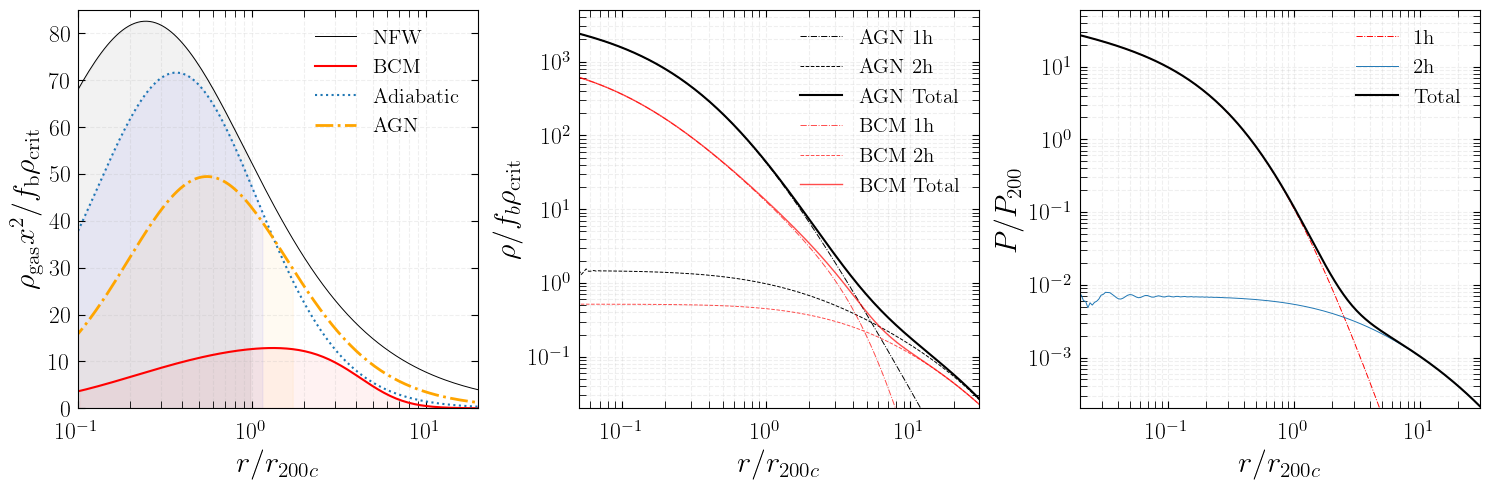

In [45]:

label_size = 17
title_size = 22
legend_size = 13
handle_length = 1.5
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))


ax = ax1
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)
ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')


# dimensonfull radial array:
r200c = M.get_r_delta_of_m_delta_at_z(200,m200c,z)
r = x_200c*r200c
theta_arcmin = M.get_rad_to_arcmin(r/M.get_dA(z))

# normalized radial array for nfw:
# r200m = M.get_r_delta_of_m_delta_at_z(200*M.Om_m(z),m200m,z)
# c200m = M.get_c200m_at_m_and_z_B13(m200m,z)
c200c = M.get_c200c_at_m_and_z_B13(m200c,z)
# rs_200m = r200m/c200m
# xs_200m =  r/rs_200m
rs_200c = r200c/c200c
xs_200c=  r/rs_200c

rho_norm_nfw = rho_gas_nfw(xs_200c,m200c,z)/M.get_rho_crit_at_z(z)/M.get_f_b()
ax1.plot(x_200c,rho_norm_nfw*x_200c**2,label = r'$\mathrm{NFW}$',c='k',lw=0.7)

t = x_200c
ft = rho_norm_nfw*x_200c**2
ax1.fill_between(
        x= t, 
        y1= ft, 
        where= (-1 < t)&(t < 1.),
        color= "black",
        alpha= 0.05)



rho_norm_bcm = rho_gas_bcm(x_200c,m200c,z)/Mbcm.get_rho_crit_at_z(z)/Mbcm.get_f_b()/norm
ax1.plot(x_200c,rho_norm_bcm*x_200c**2,label = r'$\mathrm{BCM}$',c='red',ls='-')

t = x_200c
ft =rho_norm_bcm*x_200c**2
ax1.fill_between(
        x= t, 
        y1= ft, 
        where= (0.1 < t)&(t < 10.),
        color= 'red',
        alpha= 0.05)


A_rho0 = 1.9e4
A_alpha = 0.70
A_beta = 4.43

alpha_m_rho0 = 0.09
alpha_m_alpha = -0.017
alpha_m_beta = 0.005

alpha_z_rho0 = -0.95
alpha_z_alpha = 0.27
alpha_z_beta = 0.037
gamma = -0.2
xc = 0.5

rho_norm_b16 = rho_gas_b16(x_200c,
                           m200c,
                           z,
                           A_rho0 = A_rho0,
                           A_alpha = A_alpha,
                           A_beta = A_beta,
                           alpha_m_rho0 = alpha_m_rho0,
                           alpha_m_alpha = alpha_m_alpha,
                           alpha_m_beta = alpha_m_beta,
                           alpha_z_rho0 = alpha_z_rho0,
                           alpha_z_alpha = alpha_z_alpha,
                           alpha_z_beta = alpha_z_beta,
                           gamma=gamma,
                           xc = xc)/M.get_rho_crit_at_z(z)/M.get_f_b()
ax1.plot(x_200c,rho_norm_b16*x_200c**2, label = r'$\mathrm{Adiabatic}$',ls=':')

t = x_200c
ft = rho_norm_b16*x_200c**2
ax1.fill_between(
        x= t, 
        y1= ft, 
        where= (-1 < t)&(t < xout_calc_adia),
        color= "blue",
        alpha= 0.05)


A_rho0 = 4.e3
A_alpha = 0.88
A_beta = 3.83

alpha_m_rho0 = 0.29
alpha_m_alpha = -0.03
alpha_m_beta = 0.04

alpha_z_rho0 = -0.66
alpha_z_alpha = 0.19
alpha_z_beta = -0.025
gamma = -0.2
xc = 0.5

rho_norm_b16 = rho_gas_b16(x_200c,
                           m200c,
                           z,
                           A_rho0 = A_rho0,
                           A_alpha = A_alpha,
                           A_beta = A_beta,
                           alpha_m_rho0 = alpha_m_rho0,
                           alpha_m_alpha = alpha_m_alpha,
                           alpha_m_beta = alpha_m_beta,
                           alpha_z_rho0 = alpha_z_rho0,
                           alpha_z_alpha = alpha_z_alpha,
                           alpha_z_beta = alpha_z_beta,
                           gamma=gamma,
                           xc = xc)/M.get_rho_crit_at_z(z)/M.get_f_b()
ax1.plot(x_200c,rho_norm_b16*x_200c**2, label = r'$\mathrm{AGN}$',ls='-.',c='orange',lw=2.)

t = x_200c
ft = rho_norm_b16*x_200c**2
ax1.fill_between(
        x= t, 
        y1= ft, 
        where= (-1 < t)&(t < xout_calc_agn),
        color= "orange",
        alpha= 0.05)


ax1.set_xscale('log')
ax1.set_yscale('linear')
ax1.legend(frameon=False)
ax1.set_xlabel(r'$r/r_{200c}$',size=title_size)
ax1.set_ylabel(r'$\rho_\mathrm{gas}x^2/f_\mathrm{b}\rho_\mathrm{crit}$',size=title_size)

ax.set_xlim(1e-1,2e1)
ax.set_ylim(0,85)
ax.legend(frameon=False,fontsize=15)

ax = ax2
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)
ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')
ax.set_ylabel(r"$\rho/f_b\rho_\mathrm{crit}$ ",size=title_size)
ax.set_xlabel(r"$r/r_{200c}$",size=title_size)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(2e-2,5e3)
ax.set_xlim(5e-2,3e1)
ax.plot(x_200c,rho_1h, label = r'$\mathrm{AGN\,\,1h}$',ls='-.',c='k',lw=0.7)
ax.plot(x_200c,rho_2h/M.get_rho_crit_at_z(z)/M.get_f_b(),label=r'$\mathrm{AGN\,\,2h}$',lw=0.7,c='k',ls='--')
ax.plot(x_200c,rho_2h/M.get_rho_crit_at_z(z)/M.get_f_b()+rho_1h,label=r'$\mathrm{AGN\,\,Total}$',c='k',ls='-')

ax.plot(x_200c,rho_norm_bcm,label = r'$\mathrm{BCM\,\,1h}$',ls='-.',lw=0.7,c='r',alpha=0.7)
ax.plot(x_200c,rho_2h_bcm/M.get_rho_crit_at_z(z)/M.get_f_b(),label=r'$\mathrm{BCM\,\,2h}$',lw=0.7,c='r',alpha=0.7,ls='--')
ax.plot(x_200c,rho_norm_bcm+rho_2h_bcm/M.get_rho_crit_at_z(z)/M.get_f_b(),label=r'$\mathrm{BCM\,\,Total}$',lw=1.,c='r',alpha=0.7)
# # plt.xlim(2e-2,4e1)
# plt.ylim(1e-2,1e4)
ax.legend(frameon=False,fontsize=15)


ax = ax3
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)
ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')
ax.set_ylabel(r"$P/P_{200}$ ",size=title_size)
ax.set_xlabel(r"$r/r_{200c}$",size=title_size)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(2e-4,6e1)
ax.set_xlim(2e-2,3e1)
ax.plot(x_200c,pe_1h, label = r'$\mathrm{1h}$',ls='-.',c='r',lw=0.7)
ax.plot(x_200c,pe_2h,label='$\mathrm{2h}$',ls='-',lw=0.7)
ax.plot(x_200c,pe_1h+pe_2h,label='$\mathrm{Total}$',ls='-',c='k')
ax.legend(frameon=False,fontsize=15)
fig.tight_layout()
plt.savefig('figures/Battaglia_density_and_pressure_profiles_and_2haloterms_wbcm.pdf')

In [16]:
theorynorm =  (Mbcm.get_f_b()-Mbcm.get_fstar_of_m_at_z(m200c,z))*m200c
theorynorm

3015452772689.9023

In [17]:
uk = np.vectorize(Mbcm.get_gas_density_profile_at_k_M_z)(1e-2,m200c,z,normalize=1)
uk/theorynorm

1.0308571376130498

In [22]:
lamda_out_nfw = 1.*r200c/rs_200c
print(lamda_out_nfw)
"%.3e"%np.trapz(np.asarray(4.*np.pi*rs_200c**3*rho_norm_nfw*M.get_rho_crit_at_z(z)*M.get_f_b()*xs_200c**3)[x_200c<1]/M.get_f_b(),
                x=np.log(xs_200c)[x_200c<1])

4.057777759485124


'2.198e+13'

In [19]:
"%.3e"%np.trapz(np.asarray(4.*np.pi*r200c**3*rho_norm_bcm*M.get_rho_crit_at_z(z)*M.get_f_b()*x_200c**2)[x_200c<10]
                /(Mbcm.get_f_b()-Mbcm.get_fstar_of_m_at_z(m200c,z)),
                x=x_200c[x_200c<10])

'2.210e+13'

In [20]:
"%.3e"%m200c

'2.233e+13'

In [23]:
# z=1.5
r200c = M.get_r_delta_of_m_delta_at_z(200,m200c,z)
r = x_200c*r200c
# theta_arcmin = M.get_rad_to_arcmin(r/M.get_dA(z))

# normalized radial array for nfw:
# r200m = M.get_r_delta_of_m_delta_at_z(200*M.Om_m(z),m200m,z)
# c200m = M.get_c200m_at_m_and_z_D08(m200m,z)
c200c = M.get_c200c_at_m_and_z_B13(m200c,z)
# rs_200m = r200m/c200m
# xs_200m =  r/rs_200m
rs_200c = r200c/c200c
xs_200c=  r/rs_200c
rho_gas_nfw = np.vectorize(Mbcm.get_gas_profile_at_x_M_z_nfw_200c)
def M_nfw(lambda_out):
    #lambda_out = rout/r200c
    rout = lambda_out*r200c
    lambda_out_200c = rout/rs_200c
    x_array = np.linspace(1e-4,lambda_out_200c,1000)
    y = rho_gas_nfw(x_array,m200c,z)*x_array**2
#     y = 
    mass = 4.*np.pi*rs_200c**3*np.trapz(y,x=x_array)#/M.get_f_b()
    return mass
M_nfw = np.vectorize(M_nfw)

In [24]:
"%.3e"%(M_nfw(1.)/M.get_f_b())

'2.233e+13'

In [212]:
"%.3e"%m200c

'2.233e+13'

In [145]:
def m_nfw(x):
    return np.log(1.+x)-x/(1.+x)

In [165]:
import pyccl as ccl

cosmo = ccl.Cosmology(
    Omega_b=cosmo_params['omega_b']/(cosmo_params['H0']/100.)**2,
    Omega_c=cosmo_params['omega_cdm']/(cosmo_params['H0']/100.)**2,
    h=cosmo_params['H0']/100.,
    n_s=cosmo_params['n_s'],
    A_s=float(np.exp(cosmo_params['ln10^{10}A_s'])*1e-10),
    # sigma8 = websky_cosmo['sigma8'],
    w0=-1,
    wa=0,
    m_nu=0.,
    m_nu_type='normal',
    Neff=3.046,
    Omega_k=0,
    transfer_function = 'boltzmann_class')

In [198]:

mass_def = ccl.halos.MassDef(200, 'critical')
hmf = ccl.halos.MassFuncTinker08(cosmo, mass_def=mass_def)
hbf = ccl.halos.HaloBiasTinker10(cosmo, mass_def=mass_def)
cm = ccl.halos.ConcentrationBhattacharya13(mass_def)
hmc = ccl.halos.HMCalculator(cosmo, 
                             hmf, 
                             hbf, 
                             mass_def,
                            log10M_min=10.0,
                            log10M_max=16.0,
                            )

hp = ccl.halos.HaloProfileNFW(c_M_relation=cm,truncated=False)

[]

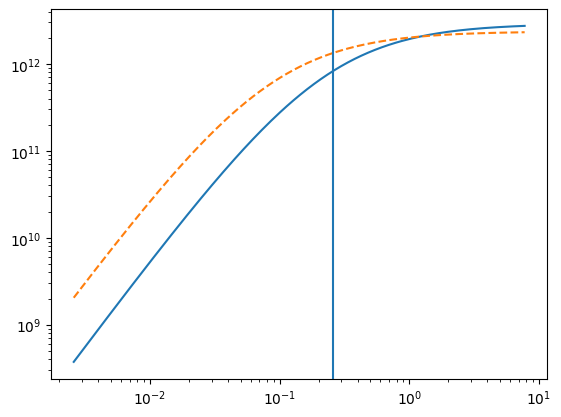

In [207]:
hcosmo= cosmo_params['H0']/100.
ccl_nfw_rho = hp._real(cosmo,r/hcosmo,m200c/hcosmo,
                       1./(1.+z),mass_def)*hcosmo**-2
# M_use = m200c
a = 1./(1.+z)
# R_M = mass_def.get_radius(cosmo, M_use, a) / a
# c_M = hp._get_cM(cosmo, M_use, a, mdef=mass_def)
# R_s = R_M / c_M
# ccl_norm = hp._norm( M_use, R_s, c_M)
ccl_norm = 1.

plt.plot(r,ccl_nfw_rho*ccl_norm*r**3)
# plt.plot(r,1e1/r**3)
plt.plot(r,rho_gas_nfw(xs_200c,m200c,z)/M.get_f_b()*r**3,ls='--')
# ccl_nfw_norm = 
plt.axvline(r200c)
plt.loglog()

In [209]:
c_M = hp._get_cM(cosmo, m200c, a, mdef=mass_def)
c_M

2.950753754954944